In [1]:
# Hyperparameters
BATCH_SIZE = 32
SEED = 1161
LEARNING_RATE = 1e-5
NUM_EPOCH = 5
WEIGHT_DECAY = 0.01

!pip install datasets evaluate transformers[sentencepiece]
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.1 MB/s eta 0:00:00


In [2]:
import datasets
import transformers
from tqdm import tqdm_notebook

In [3]:
emotions = datasets.load_dataset('dair-ai/emotion')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

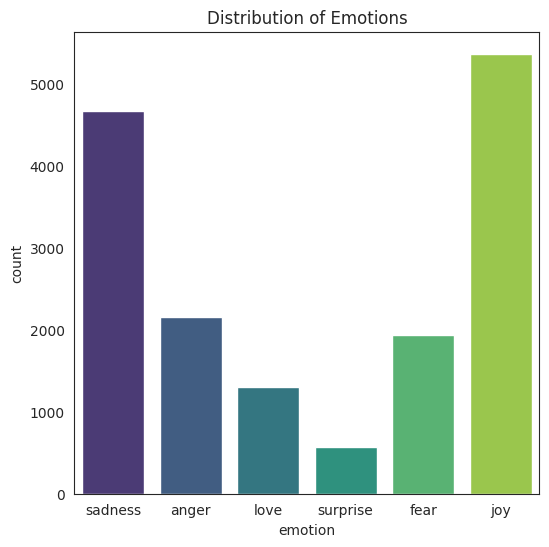

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

emotions.set_format('pandas')
df = emotions['train'][:]
def int2str_label(row):
    return emotions['train'].features['label'].int2str(row)
df['emotion'] = df['label'].apply(int2str_label)

sns.set_style('white')
plt.figure(figsize=(6,6))
sns.countplot(x='emotion', data=df, palette='viridis', hue='emotion')
plt.title('Distribution of Emotions')
plt.show()

In [5]:
emotions.reset_format()

In [6]:
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
text = "this is a text for tokenizer to convert or encode"
out = tokenizer(text)
input_ids = out.input_ids
tokenizer.convert_ids_to_tokens(input_ids)

['[CLS]',
 'this',
 'is',
 'a',
 'text',
 'for',
 'token',
 '##izer',
 'to',
 'convert',
 'or',
 'en',
 '##code',
 '[SEP]']

In [8]:
def apply_tokenizer(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

emotions_encoded = emotions.map(apply_tokenizer,batched=True,batch_size=None)
emotions_encoded.set_format(type="pt",columns=['input_ids','attention_mask','label'])

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class_labels = emotions_encoded['train'].features['label'].names
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'f1':f1, 'acc':acc}

In [12]:
#using TrainingAruguments module
from transformers import TrainingArguments

#number of logging steps needed
logging_steps = len(emotions['train'])//BATCH_SIZE
#set a dir for output
model_name = 'Sentiment_tweets_distilbert'
#set epochs
num_epochs = 5
#log level
log_level = "error"

#create instance of Training Arguments
training_args = TrainingArguments(output_dir=model_name,
                                 per_device_train_batch_size=BATCH_SIZE,
                                 per_device_eval_batch_size=BATCH_SIZE,
                                 log_level=log_level,
                                 logging_steps=logging_steps,
                                 learning_rate=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY,
                                 num_train_epochs=NUM_EPOCH,
                                 push_to_hub=True,
                                 disable_tqdm=False,
                                 eval_strategy="epoch")

In [13]:
from huggingface_hub import notebook_login
notebook_login()

In [14]:
# Code for training:
from transformers import Trainer
trainer = Trainer(model=model,
                 compute_metrics=compute_metrics,
                 args=training_args,
                 train_dataset=emotions_encoded['train'],
                 eval_dataset=emotions_encoded['validation'],
                 processing_class=tokenizer)
trainer.train()
trainer.push_to_hub(commit_message="2nd training done")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: issactai0124 (issactai0124-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1,Acc
1,0.860100,0.328630,0.900964,0.901000
2,0.241400,0.186198,0.930469,0.930500
3,0.158300,0.164775,0.934515,0.934000
4,0.123800,0.157858,0.932833,0.932500
5,0.111500,0.152494,0.937664,0.937500


events.out.tfevents.1742387480.95e9d31a55fc.819.0:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/issactai0124/Sentiment_tweets_distilbert/commit/20c33340cb7a469ecc6ed7aab93808beda5fa330', commit_message='2nd training done', commit_description='', oid='20c33340cb7a469ecc6ed7aab93808beda5fa330', pr_url=None, repo_url=RepoUrl('https://huggingface.co/issactai0124/Sentiment_tweets_distilbert', endpoint='https://huggingface.co', repo_type='model', repo_id='issactai0124/Sentiment_tweets_distilbert'), pr_revision=None, pr_num=None)

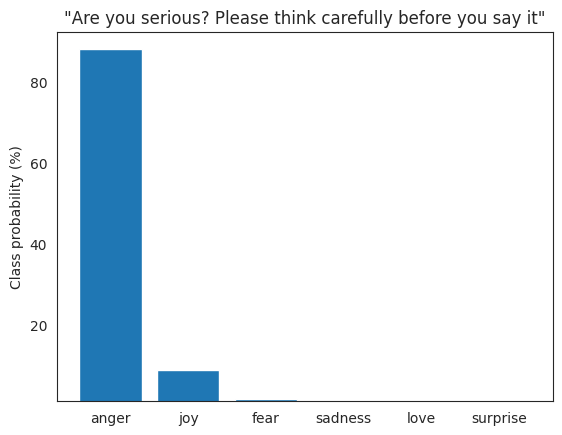

In [34]:
import pandas as pd
from transformers import pipeline
model_id = 'issactai0124/Sentiment_tweets_distilbert'
classifier = pipeline("text-classification", model=model_id)
sample_tweet = "Are you serious? Please think carefully before you say it"
preds = classifier(sample_tweet,top_k=None)
pred_df = pd.DataFrame(preds)

plt.bar(pred_df.label, 100*pred_df['score'], color='C0')
plt.title(f'"{sample_tweet}"')
plt.ylabel("Class probability (%)")
plt.ylim(1)
plt.show()

In [35]:
## Load existing model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class_labels = emotions_encoded['train'].features['label'].names
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

tokenizer = AutoTokenizer.from_pretrained("issactai0124/Sentiment_tweets_distilbert", label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained("issactai0124/Sentiment_tweets_distilbert", label2id=label2id, id2label=id2label)

In [40]:
import gradio as gr

model_id = 'issactai0124/Sentiment_tweets_distilbert'
classifier = pipeline("text-classification", model=model_id)

In [108]:
from timeit import default_timer as timer

class_names = list(classifier.model.config.id2label.values())

example_list = ["I am really surprised to see you can do that", "It's my pleasure to meet you!", "I love you"]

def predict(input):
  # Start the timer
  start_time = timer()

  pred_probs = classifier(input, top_k=None)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {pred_probs[i]['label']: pred_probs[i]['score'] for i in range(len(pred_probs))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

text_interface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(label="Enter text for sentiment classification"),  # Input component
    outputs=[gr.Label(num_top_classes=3, label="Classified sentiments"),
             gr.Number(label="Prediction time (s)")],
    examples=example_list
)

text_interface.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://24f67efa853f38df65.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
